### Manual Summarization

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import sheet_to_text

print(sheet_to_text('data/Financial_Reports/USFR_StmtNetCost_20191001_20240930.csv'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Table 1.
Columns:
[ Record Date:date ],
[ Statement Fiscal Year:numeric ],
[ Restatement Flag:categorical top:Y; N ],
[ Agency Name:categorical top:Department of Health and Human Services; Social Security Administration ],
[ Gross Cost (in Billions):numeric ],
[ Earned Revenue (in Billions):numeric ],
[ Subtotal (in Billions):numeric ],
[ Change in Assumptions (in Billions):numeric ]

Keywords:
depart, 2023-09-30, 2024-09-30, 2022-09-30, 2021-09-30, 2020-09-30, agenc, secur, administr, corpor, nation, servic, commiss, develop, state

Samples:

From Table 1:
-2023-09-30 | 2022 | Y | Total | 7420.10000000001 | 531.1 | 6889.00000000001 | 2207.9
-2023-09-30 | 2022 | Y | Subtotal | 7420.70000000001 | 531.1 | 6889.60000000001 | 2207.9
-2023-09-30 | 2022 | Y | Department of Health and Human Services | 1812.7 | 154.1 | 1658.6 | 1.4


### BERT Attention scores

In [3]:
import numpy as np
import torch
from transformers import AutoTokenizer
from train import BertTextClassifier
from utils import load_yaml, set_seed

import matplotlib.pyplot as plt
from typing import List

cfg = load_yaml('config.yaml')
set_seed(42)

tokenizer = AutoTokenizer.from_pretrained(cfg["model"]["model_name"], use_fast=True)
num_classes = len(cfg["dataset"]["categories"])
id2label = {i: c for i, c in enumerate(cfg["dataset"]["categories"])}
model = BertTextClassifier(cfg, num_classes=num_classes, id2label=id2label)

# load weights 
# model.load_state_dict(torch.load(ckpt, map_location='cpu')) 

Seed set to 42


In [4]:
model.backbone.config.output_attentions = True
model.eval()

@torch.no_grad()
def forward_with_attentions(model: BertTextClassifier, input_ids, attention_mask):
    # Forward through backbone to get attentions
    outputs = model.backbone(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    # List of length L layers: each [B, num_heads, T, T]
    attentions = outputs.attentions
    last_hidden = outputs.last_hidden_state
    
    logits = model.head(model._pool(last_hidden, attention_mask))
    return logits, attentions

In [5]:
def aggregate_attentions(
    attentions: List[torch.Tensor],
    cls_index: int = 0,
    attention_mask: torch.Tensor = None
) -> np.ndarray:
    """
    Returns token importances as a 1D numpy array length T.
    - attention scores of CLS to others from last layer
    """
    
    # attentions: list[L] of [1, H, T, T]
    A = [a[0].cpu().numpy() for a in attentions]
    L = len(A)
    H, T, _ = A[-1].shape

    if attention_mask is not None:
        mask = attention_mask[0].cpu().numpy().astype(bool)
    else:
        mask = np.ones(T, dtype=bool)

    att = A[-1].mean(axis=0) # last layer 
    scores = att[cls_index] 
    # zero out masked
    scores = np.where(mask, scores, 0.0)
    scores = scores / (scores.sum() + 1e-6)
    return scores

In [6]:
def get_attn_scores(text, verbose=False):
    enc = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    
    _, attentions = forward_with_attentions(model, input_ids, attention_mask)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    scores = aggregate_attentions(attentions, cls_index=0, attention_mask=attention_mask)
    print("Scores shape:", scores.shape)
    return scores, tokens


In [7]:
import re
PUNCT_RE = re.compile(r"[^\w]+")

# Visualize
def _normalize_token(t: str) -> str:
    t = t.replace("##", "")
    t = PUNCT_RE.sub(" ", t).strip().lower()
    return t

def visualize(tokens, scores, top_k=20, verbose=False, savefig='assets/attn_scores.png'):
    filtered = [
        (_normalize_token(t), float(s))
        for t, s in zip(tokens, scores)
        if t not in ("[CLS]", "[SEP]", "[PAD]") and len(_normalize_token(t)) > 3
    ]
    
    top = sorted(filtered, key=lambda x: x[1], reverse=True)[:top_k]
    labels = [t for t, _ in top]
    vals = np.array([v for _, v in top], dtype=float)

    if verbose:
        print("\nTop tokens by importance:")
        width = max(len(t) for t in labels) if labels else 10
        for t, v in top:
            print(f"{t:<{width}}  {v:.4f}")
        
        summary = " ".join(labels)
        print("\nHeuristic summary (top tokens):")
        print(summary)
    
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), labels, rotation=45, ha="right")
    plt.title("Token importances")
    plt.tight_layout()
    if savefig: plt.savefig(savefig, dpi=300)
    plt.show()

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



=== Category: Academic_Research ===
Scores shape: (512,)


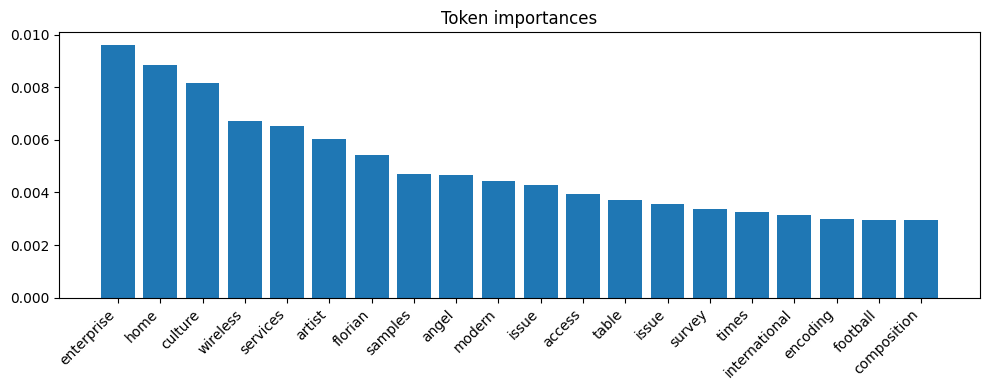


--- File: data/Academic_Research/dblp-v10.csv | Table #1 ---

Important columns:
  - authors  (tokens matched: 1)
  - venue  (tokens matched: 1)

Top rows with many important tokens:
  - row #9562  (tokens matched: 22)  :: 569059 | Web services are a consolidated reality of the modern Web with tremendous, increasing impact on everyday comput…
  - row #9344  (tokens matched: 17)  :: 235539 | In recent times, wireless access technology is becoming increasingly commonplace due to the ease of operation a…
  - row #1051  (tokens matched: 16)  :: 728182 | Abstract In Industries many projects are undertaken for execution for a specific purpose. This stands in contra…
  - row #1153  (tokens matched: 15)  :: 950260 | The Internet of Things (IoT) is the intelligent technologies and services that mutually communicate information…
  - row #3377  (tokens matched: 14)  :: 258044 | As the Internet grows quickly, more and more services are available. How to provide high quality, convenient, a…
  - ro

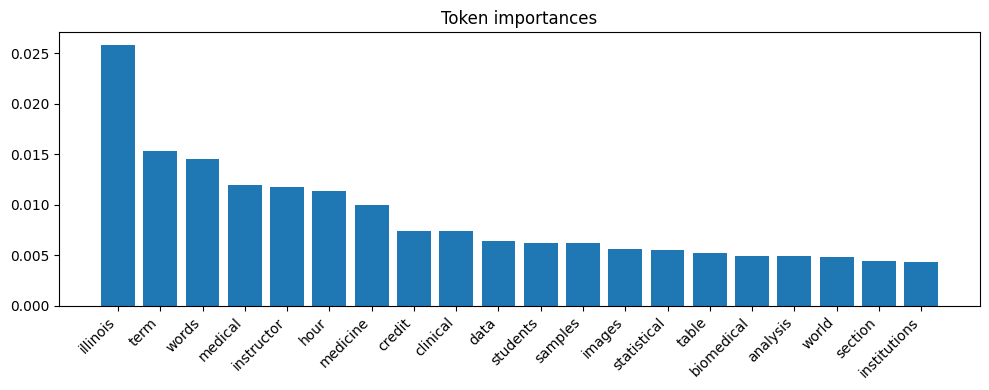


--- File: data/Academic_Research/course-catalog.csv | Table #1 ---

Important columns:
  - Section Credit Hours  (tokens matched: 4)
  - Credit Hours  (tokens matched: 3)
  - Term  (tokens matched: 1)
  - YearTerm  (tokens matched: 1)
  - Section Info  (tokens matched: 1)
  - Section  (tokens matched: 1)
  - Part of Term  (tokens matched: 1)
  - Section Title  (tokens matched: 1)
  - Section Status  (tokens matched: 1)
  - Instructors  (tokens matched: 1)

Top rows with many important tokens:
  - row #2682  (tokens matched: 32)  :: 2025 | Spring | 2025-sp | CLE | 799 | Advanced Clinical Electives | Phase 2 and Phase 3 students are eligible to partici…
  - row #2683  (tokens matched: 32)  :: 2025 | Spring | 2025-sp | CLE | 799 | Advanced Clinical Electives | Phase 2 and Phase 3 students are eligible to partici…
  - row #2684  (tokens matched: 32)  :: 2025 | Spring | 2025-sp | CLE | 799 | Advanced Clinical Electives | Phase 2 and Phase 3 students are eligible to partici…
  - row #2685  

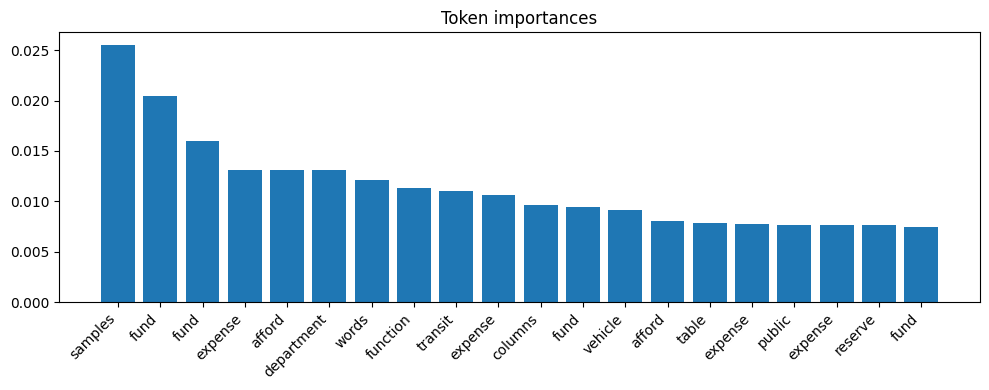


--- File: data/Financial_Reports/Budget_and_Actuals_2196472263152831116.csv | Table #1 ---

Important columns:
  - Fiscal Year  (tokens matched: 2)
  - Account Type  (tokens matched: 2)
  - Fund  (tokens matched: 1)
  - Function  (tokens matched: 1)
  - Department  (tokens matched: 1)
  - Division  (tokens matched: 1)
  - Category  (tokens matched: 1)

Top rows with many important tokens:
  - row #136  (tokens matched: 12)  :: 137 | nan | GENERAL FUND | ENVIRONMENT & DEVELOPMENT | PUBLIC WORKS | EXPENSE | nan | 25000 | 25000 | 0 | nan
  - row #652  (tokens matched: 12)  :: 653 | nan | GENERAL FUND | ENVIRONMENT & DEVELOPMENT | PUBLIC WORKS | EXPENSE | nan | 758283 | 701373 | 680301 | nan
  - row #1046  (tokens matched: 12)  :: 1047 | nan | GENERAL FUND | ENVIRONMENT & DEVELOPMENT | PUBLIC WORKS | EXPENSE | nan | 1137029 | 1880047 | 1883657 | nan
  - row #20  (tokens matched: 11)  :: 21 | nan | GENERAL FUND | ENVIRONMENT & DEVELOPMENT | PUBLIC WORKS | EXPENSE | nan | 427140 | 432254 | 

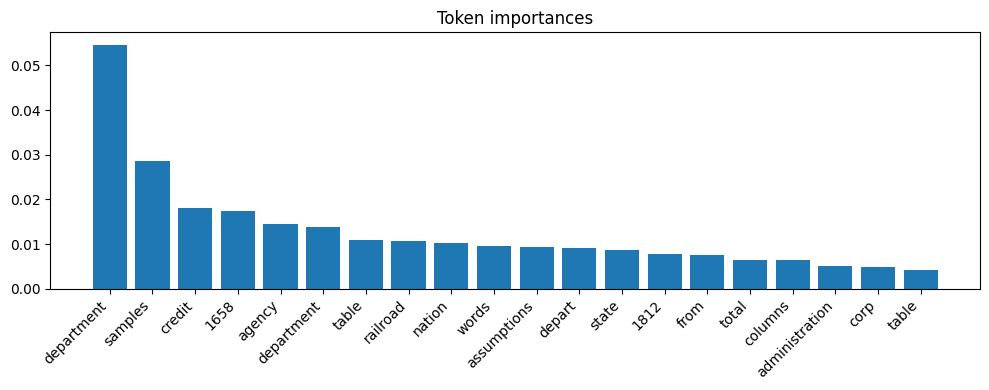


--- File: data/Financial_Reports/USFR_StmtNetCost_20191001_20240930.csv | Table #1 ---

Important columns:
  - Statement Fiscal Year  (tokens matched: 4)
  - Restatement Flag  (tokens matched: 4)
  - Agency Name  (tokens matched: 2)
  - Subtotal (in Billions)  (tokens matched: 2)
  - Change in Assumptions (in Billions)  (tokens matched: 2)
  - Record Date  (tokens matched: 1)
  - Gross Cost (in Billions)  (tokens matched: 1)
  - Earned Revenue (in Billions)  (tokens matched: 1)
  - Net Cost (in Billions)  (tokens matched: 1)
  - Fiscal Year  (tokens matched: 1)

Top rows with many important tokens:
  - row #126  (tokens matched: 12)  :: 2023-09-30 | 2022 | Y | Department of Health and Human Services | 1812.7 | 154.1 | 1658.6 | 1.4 | 1660.0 | 1 | 2023 | 4 …
  - row #171  (tokens matched: 12)  :: 2022-09-30 | 2022 | N | Department of Health and Human Services | 1812.7 | 154.1 | 1658.6 | 1.4 | 1660.0 | 2 | 2022 | 4 …
  - row #296  (tokens matched: 11)  :: 2021-09-30 | 2020 | Y | Departme

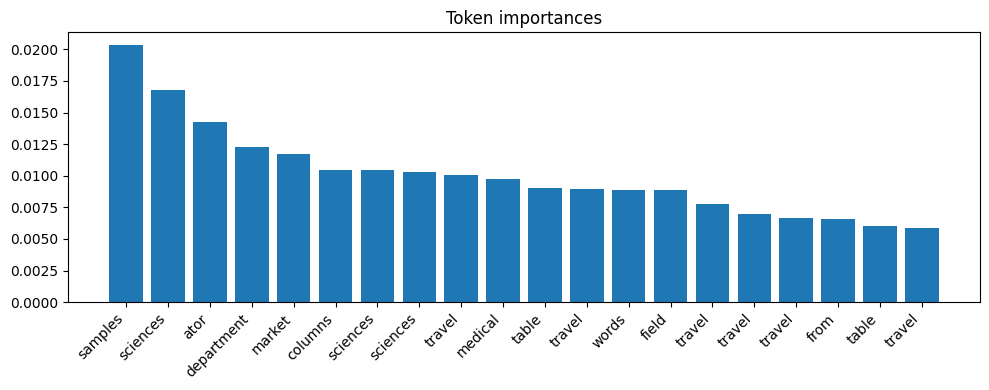


--- File: data/HR_Records/WA_Fn-UseC_-HR-Employee-Attrition.csv | Table #1 ---

Important columns:
  - BusinessTravel  (tokens matched: 4)
  - DistanceFromHome  (tokens matched: 3)
  - EducationField  (tokens matched: 3)
  - Attrition  (tokens matched: 2)
  - DailyRate  (tokens matched: 2)
  - Education  (tokens matched: 2)
  - StockOptionLevel  (tokens matched: 2)
  - Age  (tokens matched: 1)
  - Department  (tokens matched: 1)
  - EnvironmentSatisfaction  (tokens matched: 1)

Top rows with many important tokens:
  - row #288  (tokens matched: 18)  :: 26 | Yes | Travel_Rarely | 1449 | Research & Development | 16 | 4 | Medical | 1 | 394 | 1 | Male | 45 | 3 | 1 | Laborato…
  - row #6  (tokens matched: 17)  :: 59 | No | Travel_Rarely | 1324 | Research & Development | 3 | 3 | Medical | 1 | 10 | 3 | Female | 81 | 4 | 1 | Laborator…
  - row #57  (tokens matched: 17)  :: 35 | No | Travel_Rarely | 1142 | Research & Development | 23 | 4 | Medical | 1 | 75 | 3 | Female | 30 | 3 | 1 | Laborato…

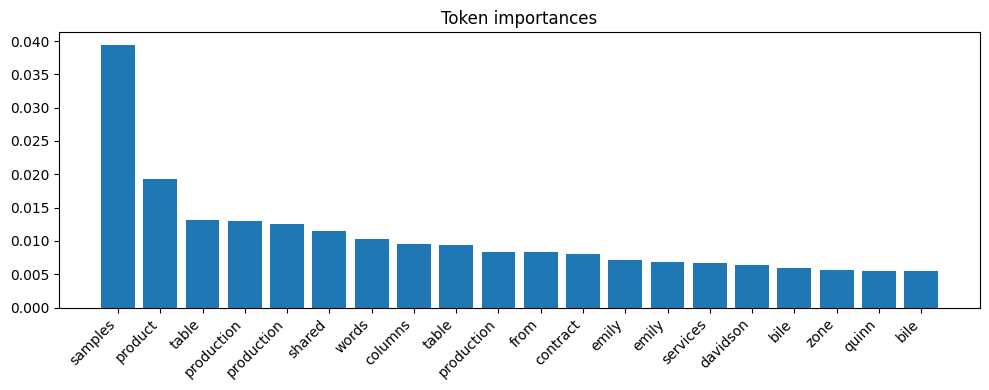


--- File: data/HR_Records/employee_data.csv | Table #1 ---

Important columns:
  - StartDate  (tokens matched: 2)
  - ExitDate  (tokens matched: 2)
  - FirstName  (tokens matched: 1)
  - LastName  (tokens matched: 1)
  - Supervisor  (tokens matched: 1)
  - ADEmail  (tokens matched: 1)
  - PayZone  (tokens matched: 1)
  - DepartmentType  (tokens matched: 1)
  - MaritalDesc  (tokens matched: 1)

Top rows with many important tokens:
  - row #1978  (tokens matched: 22)  :: 2405 | Emily | Davidson | 13-Sep-20 | 15-Mar-22 | President & CEO | Jackie Walsh | emily.davidson@bilearner.com | SVG | …
  - row #212  (tokens matched: 19)  :: 3639 | Jaylen | Acosta | 19-Sep-19 | 14-Apr-20 | Production Technician I | Mark Knight | jaylen.acosta@bilearner.com | C…
  - row #825  (tokens matched: 19)  :: 1252 | Fabian | Young | 11-Mar-22 | 25-Apr-22 | Production Manager | Timothy Hester | fabian.young@bilearner.com | EW | …
  - row #1856  (tokens matched: 19)  :: 2283 | Sean | Quinn | 03-Oct-18 | 27-Jun-

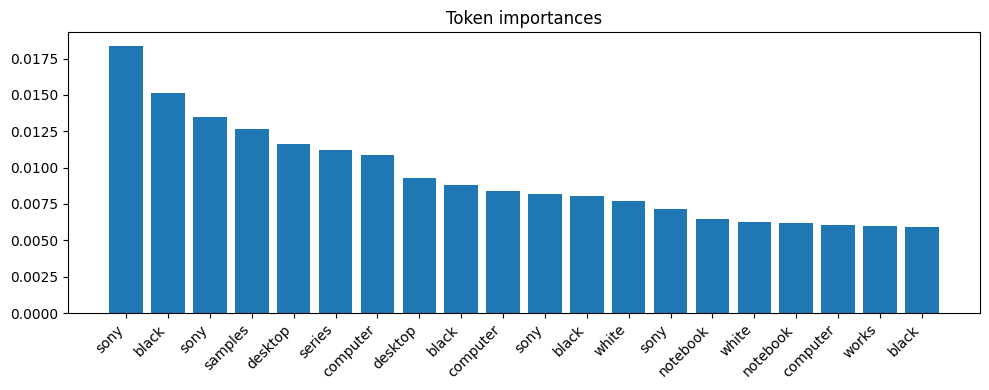


--- File: data/Product_Catalog/Product_Dataset.csv | Table #1 ---

Important columns:
  - price  (tokens matched: 1)

Top rows with many important tokens:
  - row #0  (tokens matched: 15)  :: 552 | Sony Turntable - PSLX350H | Sony Turntable - PSLX350H/ Belt Drive System/ 33-1/3 and 45 RPM Speeds/ Servo Speed Co…
  - row #1016  (tokens matched: 15)  :: 38400 | Sony VAIO JS Series Black All-In-One Desktop Computer - VGCJS130JB | Sony VAIO JS Series Black All-In-One Deskto…
  - row #929  (tokens matched: 14)  :: 37293 | Sony VAIO AW Series Titanium Grey Notebook Computer - VGNAW110JH | Sony VAIO AW Series Titanium Grey Notebook Co…
  - row #1080  (tokens matched: 14)  :: 39179 | Linksys Wireless-G Range Expander - WRE54G | Linksys Wireless-G Range Expander - WRE54G/ Supports 64/128-Bit WEP…
  - row #680  (tokens matched: 13)  :: 34881 | Sony 32' BRAVIA L-Series Black LCD Flat Panel HDTV - KDL32L4000 | Sony 32' BRAVIA L-Series Black LCD Flat Panel …
  - row #789  (tokens matched: 13)  :: 

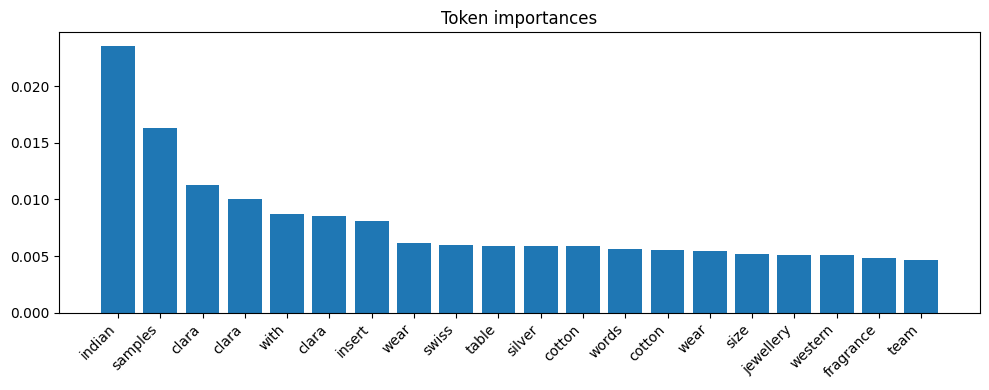


--- File: data/Product_Catalog/Message Group - Product.csv | Table #1 ---

Important columns:
  - Product Size  (tokens matched: 2)
  - BrandName  (tokens matched: 1)
  - Product ID  (tokens matched: 1)
  - Product Name  (tokens matched: 1)
  - Brand Desc  (tokens matched: 1)

Top rows with many important tokens:
  - row #4321  (tokens matched: 14)  :: 4322 | clovia | CLOVIA99 | CLOVIA99 - Lingerie&Nightwear-Women | womens cotton mid waist hipster panty with lace insert …
  - row #483  (tokens matched: 13)  :: 484 | allen solly | ALLEN SOLLY18 | ALLEN SOLLY18 - Westernwear-Women | printed polyester cotton round neck womens regul…
  - row #489  (tokens matched: 13)  :: 490 | allen solly | ALLEN SOLLY24 | ALLEN SOLLY24 - Westernwear-Women | printed polyester cotton round neck womens regul…
  - row #491  (tokens matched: 13)  :: 492 | allen solly | ALLEN SOLLY26 | ALLEN SOLLY26 - Westernwear-Women | printed polyester cotton round neck womens regul…
  - row #571  (tokens matched: 13)  :: 

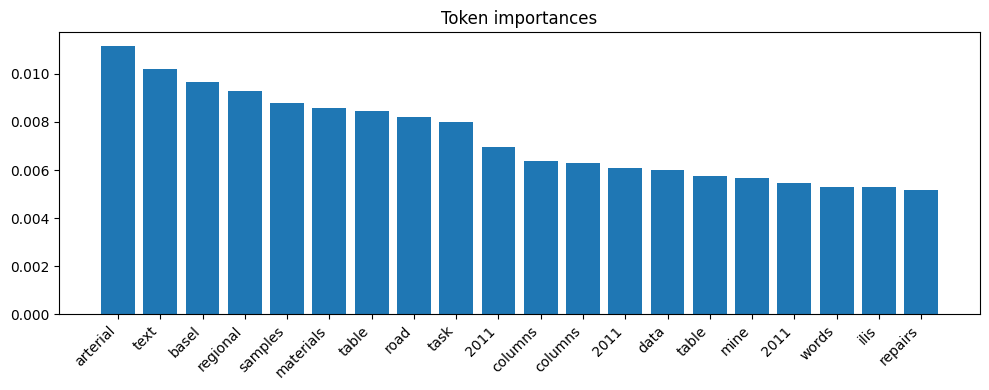


--- File: data/Project_Management/EDM - P021 - P04 - Regional Arterial Road.xlsx | Table #1 ---

Important columns:
  - P04 - Regional Arterial Road Repairs  (tokens matched: 4)
  - nan  (tokens matched: 1)
  - nan.1  (tokens matched: 1)
  - nan.2  (tokens matched: 1)
  - nan.5  (tokens matched: 1)
  - nan.6  (tokens matched: 1)
  - nan.7  (tokens matched: 1)
  - nan.8  (tokens matched: 1)
  - nan.9  (tokens matched: 1)
  - nan.10  (tokens matched: 1)

Top rows with many important tokens:
  - row #0  (tokens matched: 4)  :: Project Start | nan | 2011-05-03 00:00:00 | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan …
  - row #4  (tokens matched: 4)  :: TASK | DURn | START | END | DAYS | M | T | W | T | F | S | S | M | T | W | T | F | S | S | M | T | W | T | F | S | S | M…
  - row #1  (tokens matched: 3)  :: Display Week | nan | 1 | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan | nan |…
  - row #2  (tokens matched: 1)

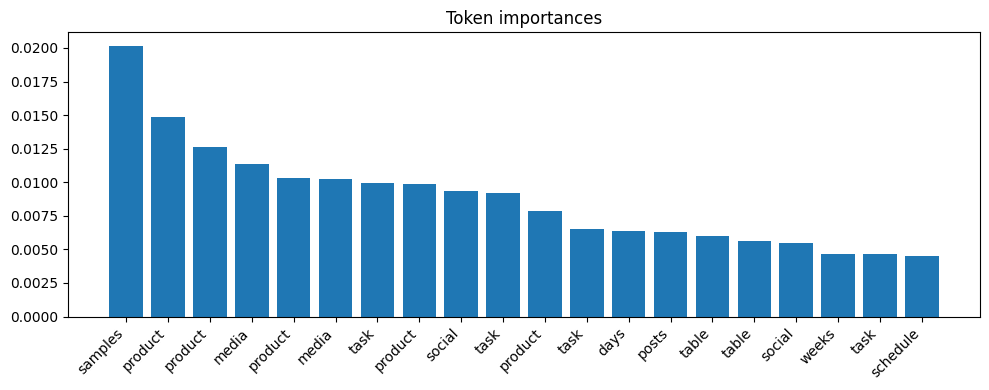


--- File: data/Project_Management/IC-Product-Launch-Gantt-Chart-Example.xlsx | Table #1 ---

Important columns:
  - Product Launch Gantt Chart Template Example  (tokens matched: 7)
  - nan.3  (tokens matched: 1)

Top rows with many important tokens:
  - row #0  (tokens matched: 5)  :: PRODUCT LAUNCH PLAN | START DATE
  - row #1  (tokens matched: 3)  :: Project Beta | 2025-03-31 00:00:00

--- File: data/Project_Management/IC-Product-Launch-Gantt-Chart-Example.xlsx | Table #2 ---

Important columns:
  - Use "BLANK" version tab for additional Task listings and weeks.  (tokens matched: 6)
  - nan  (tokens matched: 1)
  - nan.1  (tokens matched: 1)
  - nan.2  (tokens matched: 1)
  - nan.3  (tokens matched: 1)
  - nan.4  (tokens matched: 1)
  - nan.5  (tokens matched: 1)
  - nan.6  (tokens matched: 1)
  - nan.7  (tokens matched: 1)
  - nan.8  (tokens matched: 1)

Top rows with many important tokens:
  - row #18  (tokens matched: 11)  :: Define social media strategy | Complete | HIGH | nan |

In [8]:
import pandas as pd
from utils import read_sheet

df = pd.read_csv('dataset.csv')

def extract_important_tokens(tokens,
                            scores,
                            top_k=50,
                            min_len=3):
    """Return top_k normalized important tokens (unique, order by score)."""
    pairs = [
        (_normalize_token(t), float(s))
        for t, s in zip(tokens, scores)
        if t not in ("[CLS]", "[SEP]", "[PAD]")
    ]
    # drop empties / short
    pairs = [(t, s) for t, s in pairs if len(t) >= min_len]
    pairs.sort(key=lambda x: x[1], reverse=True)

    seen = set()
    uniq = []
    for t, s in pairs:
        if t not in seen:
            uniq.append((t, s))
            seen.add(t)
    pairs = uniq
    return [t for t, _ in pairs[:top_k]]


def score_columns(df: pd.DataFrame, important_tokens: list):
    col_scores = []
    for col in df.columns:
        col_norm = _normalize_token(str(col))
        words = set(col_norm.split())
        
        # score: count distinct important tokens seen in header
        matched = 0
        for tok in important_tokens:
            if tok in words or tok in col_norm:
                matched += 1
        if matched > 0:
            col_scores.append((col, matched))
    col_scores.sort(key=lambda x: x[1], reverse=True)
    return col_scores

def score_rows(df: pd.DataFrame, important_tokens: list):
    row_scores = []
    for idx, row in df.iterrows():
        merged = " ".join(_normalize_token(str(v)) for v in row.values)
        words = set(merged.split())
        matched = 0
        for tok in important_tokens:
            # count presence once per token
            if tok in words or tok in merged:
                matched += 1
        if matched > 0:
            row_scores.append((idx, matched))
    row_scores.sort(key=lambda x: x[1], reverse=True)
    return row_scores

def print_important_from_table(table: pd.DataFrame, important_tokens: list, top_k_cols=10, top_k_rows=10):
    # Columns
    col_scores = score_columns(table, important_tokens)
    if col_scores:
        print("\nImportant columns:")
        for col, sc in col_scores[:top_k_cols]:
            print(f"  - {col}  (tokens matched: {sc})")
    else:
        print("\nImportant columns: none matched")

    # Rows
    row_scores = score_rows(table, important_tokens)
    if row_scores:
        print("\nTop rows with many important tokens:")
        shown = 0
        for idx, sc in row_scores[:top_k_rows]:
            # show a compact preview of the row (first 120 chars of joined string)
            preview = " | ".join(str(v) for v in table.loc[idx].values)
            preview = (preview[:120] + "…") if len(preview) > 120 else preview
            print(f"  - row #{idx}  (tokens matched: {sc})  :: {preview}")
            shown += 1
    else:
        print("\nTop rows with many important tokens: none matched")

for cat, g in df.groupby("category"):
    print(f"\n=== Category: {cat} ===")
    for _, row in g.iterrows():
        text = row['content']
        scores, tokens = get_attn_scores(text)
        visualize(tokens, scores, savefig='')
        important_tokens = extract_important_tokens(tokens, scores, top_k=50)

        tables = read_sheet(row['file_path'])
        if isinstance(tables, pd.DataFrame):
            tables = [tables]

        for i, table in enumerate(tables):
            print(f"\n--- File: {row['file_path']} | Table #{i+1} ---")
            print_important_from_table(table, important_tokens, top_k_cols=10, top_k_rows=10)

            